# Initial Libraries

In [1]:
import pandas as pd 
import numpy as np 
import math
from scipy.stats import ttest_ind
from scipy.stats import ttest_rel
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon
import matplotlib.pyplot as plt

# Data Import and Cleaning

In [2]:
# Import the basic data

pre_data_base = pd.read_csv('pre_responses.csv')  
post_data_base = pd.read_csv('post_responses.csv')
post_data_base.head()

,Timestamp,Which visualisation did you use?,How much did the visualisation benefit your understanding?,About how far above the Earth are geostationary satellites? (in terms of the radius of the Earth),About how far above the Earth are Low Earth Orbit satellites? (in terms of the radius of the Earth),"When a satellite gets closer to the Earth in its orbit, does its speed:",About how many satellites are in orbit?,"Compared to satellites further away from the earth, do lower orbit satellites:",What did you find helped the most with your understanding?,What aspect of the visualisation could use the most improvement?
0,07/09/2022 09:19:12,Augmented Reality,3,1.0,3.000,Speed up,250,Move faster,NaN,Goggles didn’t fit as well/had latency errors.
1,07/09/2022 09:21:21,Augmented Reality,3,8.0,0.080,Speed up,1000,Move faster,The visualisation from space,Wearing the glasses can be disorienting. Unsur...
2,07/09/2022 09:29:26,Augmented Reality,5,6.0,0.100,Slow down,4000,Move slower,Understanding the position of the satellites r...,An introduction /onboarding process with a des...
3,07/09/2022 09:37:01,Augmented Reality,3,40000.0,10000.000,Speed up,1000,Move faster,the orbit of the satellites,Maybe specify what does each different colour ...
4,07/09/2022 09:40:17,Augmented Reality,4,35800.0,0.313,Speed up,4550,Move slower,The mode and the speed setting of the moving o...,"Ground view, it can not really show the positi..."


In [3]:
#Remove timestamps and open textbox commentary

pre_data = pre_data_base.drop(columns=['Timestamp'])
post_data = post_data_base.drop(columns=[
    'Timestamp',
    'What did you find helped the most with your understanding?',
    'What aspect of the visualisation could use the most improvement?',
])

In [4]:
# Rename columns for easier indexing

pre_data = pre_data.rename(columns={
    "Which visualisation did you use?":"Visualisation",
    "How would you rate your prior knowledge of satellites?": "PriorKnowledge", 
    "About how far above the Earth are geostationary satellites? (in terms of the radius of the Earth)": "GeoHeight",
    "About how far above the Earth are Low Earth Orbit satellites? (in terms of the radius of the Earth)": "LeoHeight",
    "When a satellite gets closer to the Earth in its orbit, does its speed:": "Close",
    "About how many satellites are in orbit?": "SatNum",
    "Compared to satellites further away from the earth, do lower orbit satellites:": "OrbitSpeed",
})
post_data = post_data.rename(columns={
    "Which visualisation did you use?":"Visualisation",
    "How much did the visualisation benefit your understanding?": "ImproveKnowledge", 
    "About how far above the Earth are geostationary satellites? (in terms of the radius of the Earth)": "GeoHeight",
    "About how far above the Earth are Low Earth Orbit satellites? (in terms of the radius of the Earth)": "LeoHeight",
    "When a satellite gets closer to the Earth in its orbit, does its speed:": "Close",
    "About how many satellites are in orbit?": "SatNum",
    "Compared to satellites further away from the earth, do lower orbit satellites:": "OrbitSpeed",
})
post_data.head()


,Visualisation,ImproveKnowledge,GeoHeight,LeoHeight,Close,SatNum,OrbitSpeed
0,Augmented Reality,3,1.0,3.000,Speed up,250,Move faster
1,Augmented Reality,3,8.0,0.080,Speed up,1000,Move faster
2,Augmented Reality,5,6.0,0.100,Slow down,4000,Move slower
3,Augmented Reality,3,40000.0,10000.000,Speed up,1000,Move faster
4,Augmented Reality,4,35800.0,0.313,Speed up,4550,Move slower


A number of responders input numbers that are close to the true value of the geostationary height in kilometers, or input values that are much larger than would be possible, given that the inital question asked in terms of the radius of the Earth. As a result, a cutoff of 1000 was chosen, and any value above would be interpreted as in km, and any value below in terms of the radius of the Earth.

In [5]:
# Transform all values above the threshold from km into earth radii

radius_threshold = 1000
earth_radius = 6370 # in km
pre_data.GeoHeight = pre_data.GeoHeight.apply(lambda x: x/earth_radius if x >= radius_threshold else x)
pre_data.LeoHeight = pre_data.LeoHeight.apply(lambda x: x/earth_radius if x >= radius_threshold else x)
post_data.GeoHeight = post_data.GeoHeight.apply(lambda x: x/earth_radius if x >= radius_threshold else x)
post_data.LeoHeight = post_data.LeoHeight.apply(lambda x: x/earth_radius if x >= radius_threshold else x)
post_data.head()

,Visualisation,ImproveKnowledge,GeoHeight,LeoHeight,Close,SatNum,OrbitSpeed
0,Augmented Reality,3,1.000000,3.000000,Speed up,250,Move faster
1,Augmented Reality,3,8.000000,0.080000,Speed up,1000,Move faster
2,Augmented Reality,5,6.000000,0.100000,Slow down,4000,Move slower
3,Augmented Reality,3,6.279435,1.569859,Speed up,1000,Move faster
4,Augmented Reality,4,5.620094,0.313000,Speed up,4550,Move slower


# Data Analysis

## Post-Visualisation Comparison

In astrophysics, data often spans many orders of magnitude. To help compensate for this, and equally weight errors that underestimate and overestimate the true values, the logarithm of the heights and the number of satellites are taken. This means that an estimate of 10 and 1000 (where the true value is 100) are counted equally, rather than the latter having ten times the weight.

In [6]:
# Take the logs of all the lines

pre_data_log = pre_data;
pre_data_log.GeoHeight = np.log10(pre_data_log.GeoHeight)
pre_data_log.LeoHeight = np.log10(pre_data_log.LeoHeight)
pre_data_log.SatNum = np.log10(pre_data_log.SatNum)

post_data_log = post_data;
post_data_log.GeoHeight = np.log10(post_data_log.GeoHeight)
post_data_log.LeoHeight = np.log10(post_data_log.LeoHeight)
post_data_log.SatNum = np.log10(post_data_log.SatNum)

post_data_log.head()

,Visualisation,ImproveKnowledge,GeoHeight,LeoHeight,Close,SatNum,OrbitSpeed
0,Augmented Reality,3,0.000000,0.477121,Speed up,2.397940,Move faster
1,Augmented Reality,3,0.903090,-1.096910,Speed up,3.000000,Move faster
2,Augmented Reality,5,0.778151,-1.000000,Slow down,3.602060,Move slower
3,Augmented Reality,3,0.797921,0.195861,Speed up,3.000000,Move faster
4,Augmented Reality,4,0.749744,-0.504456,Speed up,3.658011,Move slower


Unfortunately, since TAROT has different data sources and formats, the list of Two Line Elements that it uses was different to the augmented reality version. As a result, the two have different numbers of satellites.

In [7]:
# Establish the true values

true_geo_height = 35800 / earth_radius
true_leo_height = 400 / earth_radius # Altitude of ISS
true_sat_num_ar = 6350 # Value for AR
true_sat_num_2d = 7850 # Value from TAROT, 26/09/2022

log_geo_height = np.log10(true_geo_height)
log_leo_height = np.log10(true_leo_height)
log_sat_num_ar = np.log10(true_sat_num_ar)
log_sat_num_2d = np.log10(true_sat_num_2d)


In [8]:
# Take the difference of the data from the true value

pre_data_diff = pre_data_log
pre_data_diff.GeoHeight = pre_data_diff.GeoHeight - log_geo_height
pre_data_diff.LeoHeight = pre_data_diff.LeoHeight - log_leo_height

pre_data_diff.loc[pre_data_diff['Visualisation']=='TAROT (2D)', 'SatNum'] -= log_sat_num_2d
pre_data_diff.loc[pre_data_diff['Visualisation']=='Augmented Reality', 'SatNum'] -= log_sat_num_ar

post_data_diff = post_data_log
post_data_diff.GeoHeight = post_data_diff.GeoHeight - log_geo_height
post_data_diff.LeoHeight = post_data_diff.LeoHeight - log_leo_height

post_data_diff.loc[post_data_diff['Visualisation']=='TAROT (2D)', 'SatNum'] -= log_sat_num_2d
post_data_diff.loc[post_data_diff['Visualisation']=='Augmented Reality', 'SatNum'] -= log_sat_num_ar

In [9]:
# Replace the multiple choice answers with True/False binaries

pre_data_diff.Close = (pre_data_diff.Close == "Speed up")
pre_data_diff.OrbitSpeed = (pre_data_diff.OrbitSpeed == "Move faster")

post_data_diff.Close = (post_data_diff.Close == "Speed up")
post_data_diff.OrbitSpeed = (post_data_diff.OrbitSpeed == "Move faster")

post_data_diff.head()

,Visualisation,ImproveKnowledge,GeoHeight,LeoHeight,Close,SatNum,OrbitSpeed
0,Augmented Reality,3,-0.749744,1.679201,True,-1.404834,True
1,Augmented Reality,3,0.153346,0.105169,True,-0.802774,True
2,Augmented Reality,5,0.028408,0.202079,False,-0.200714,False
3,Augmented Reality,3,0.048177,1.397940,True,-0.802774,True
4,Augmented Reality,4,0.000000,0.697624,True,-0.144762,False


Now that the data has been formatted to contain the differences of the logs, we can compare the AR and 2D visualisations using a T test for the numerical answers, and a Mann-Whitney U test for the categorical answers

In [10]:
# Split into the 2 visualisation groups

post_2d_diff = post_data_diff[post_data_diff['Visualisation']=='TAROT (2D)']
post_ar_diff = post_data_diff[post_data_diff['Visualisation']=='Augmented Reality']


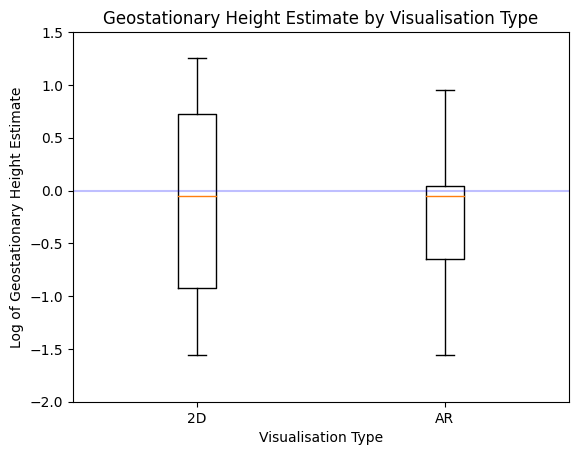

In [11]:
plt.boxplot([post_2d_diff['GeoHeight'], post_ar_diff['GeoHeight']])
plt.xticks([1, 2], ['2D', 'AR'])

plt.ylabel('Log of Geostationary Height Estimate')
plt.xlabel('Visualisation Type')
plt.title("Geostationary Height Estimate by Visualisation Type")

plt.ylim(-2, 1.5)
plt.axhline(y=0, color='b', linestyle='-', alpha=0.25)

plt.show()

In [12]:
# Perform the actual t test for the geostationary height
ttest_ind(post_2d_diff['GeoHeight'], post_ar_diff['GeoHeight'], alternative="two-sided")

Ttest_indResult(statistic=0.309460376904975, pvalue=0.7600210272106702)

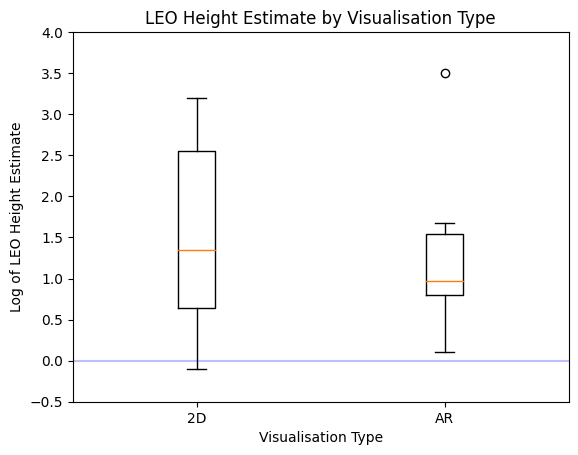

In [13]:
plt.boxplot([post_2d_diff['LeoHeight'], post_ar_diff['LeoHeight']])
plt.xticks([1, 2], ['2D', 'AR'])

plt.ylabel('Log of LEO Height Estimate')
plt.xlabel('Visualisation Type')
plt.title("LEO Height Estimate by Visualisation Type")

plt.ylim(-0.5, 4)
plt.axhline(y=0, color='b', linestyle='-', alpha=0.25)

plt.show()

In [14]:
# Perform the actual t test for the low earth orbit height
ttest_ind(post_2d_diff['LeoHeight'], post_ar_diff['LeoHeight'], alternative="two-sided")

Ttest_indResult(statistic=0.10129594417177896, pvalue=0.9202764750969769)

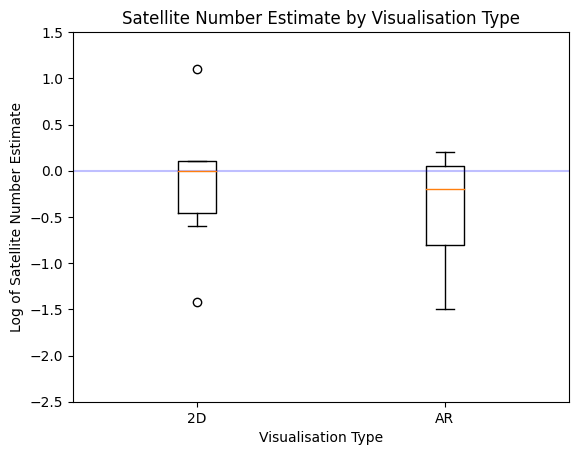

In [15]:
plt.boxplot([post_2d_diff['SatNum'], post_ar_diff['SatNum']])
plt.xticks([1, 2], ['2D', 'AR'])

plt.ylabel('Log of Satellite Number Estimate')
plt.xlabel('Visualisation Type')
plt.title("Satellite Number Estimate by Visualisation Type")

plt.ylim(-2.5, 1.5)
plt.axhline(y=0, color='b', linestyle='-', alpha=0.25)

plt.show()

In [16]:
# Perform the actual t test for the number of satellites
ttest_ind(post_2d_diff['SatNum'], post_ar_diff['SatNum'], alternative="two-sided")

Ttest_indResult(statistic=1.266668058617863, pvalue=0.2191434707920235)

These three tests seem to indicate a lack of significant difference between the two populations in terms of the numerical answers.

In [17]:
# Perform the actual test for the subjective knowledge rating
mannwhitneyu(post_2d_diff['ImproveKnowledge'], post_ar_diff['ImproveKnowledge'], method="exact")

MannwhitneyuResult(statistic=50.0, pvalue=0.3469992115839471)

In [18]:
# Perform the actual test for the closer satellite speed
mannwhitneyu(post_2d_diff['Close'], post_ar_diff['Close'], method="exact")

MannwhitneyuResult(statistic=39.5, pvalue=0.11792810769792868)

In [19]:
# Perform the actual test for the variable orbit speed
mannwhitneyu(post_2d_diff['OrbitSpeed'], post_ar_diff['OrbitSpeed'], method="exact")

MannwhitneyuResult(statistic=74.5, pvalue=0.650549746390371)

These three tests also indicate no significant difference between the two populations for any of the questions. This means that the current data does not display an observable difference between the 2D and AR populations. 

## Pre-Visualisation Comparison

With no results from the post-visualisation comparison

In [20]:
# Split into the 2 visualisation groups

pre_2d_diff = pre_data_diff[pre_data_diff['Visualisation']=='TAROT (2D)']
pre_ar_diff = pre_data_diff[pre_data_diff['Visualisation']=='Augmented Reality']

### 2D Visualisation

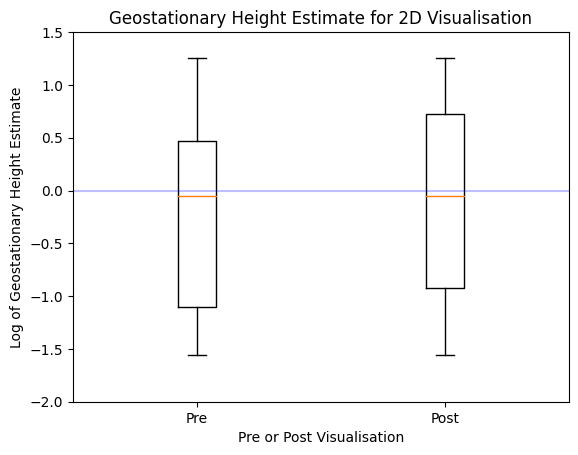

In [21]:
plt.boxplot([pre_2d_diff['GeoHeight'], post_2d_diff['GeoHeight']])
plt.xticks([1, 2], ['Pre', 'Post'])

plt.ylabel('Log of Geostationary Height Estimate')
plt.xlabel('Pre or Post Visualisation')
plt.title("Geostationary Height Estimate for 2D Visualisation")

plt.ylim(-2, 1.5)
plt.axhline(y=0, color='b', linestyle='-', alpha=0.25)

plt.show()

In [22]:
# Perform the actual t test for the geostationary height
ttest_rel(pre_2d_diff['GeoHeight'], post_2d_diff['GeoHeight'], alternative="two-sided")

Ttest_relResult(statistic=0.42847488000330974, pvalue=0.6765751447606401)

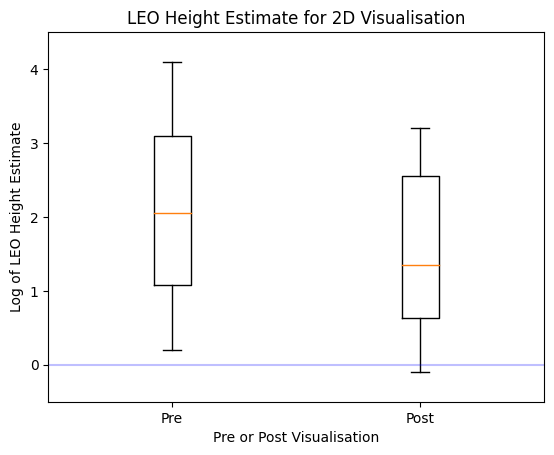

In [23]:
plt.boxplot([pre_2d_diff['LeoHeight'], post_2d_diff['LeoHeight']])
plt.xticks([1, 2], ['Pre', 'Post'])

plt.ylabel('Log of LEO Height Estimate')
plt.xlabel('Pre or Post Visualisation')
plt.title("LEO Height Estimate for 2D Visualisation")

plt.ylim(-0.5, 4.5)
plt.axhline(y=0, color='b', linestyle='-', alpha=0.25)

plt.show()

In [24]:
# Perform the actual t test for the LEO height
ttest_rel(pre_2d_diff['LeoHeight'], post_2d_diff['LeoHeight'], alternative="two-sided")

Ttest_relResult(statistic=2.204228938261834, pvalue=0.04971746491590412)

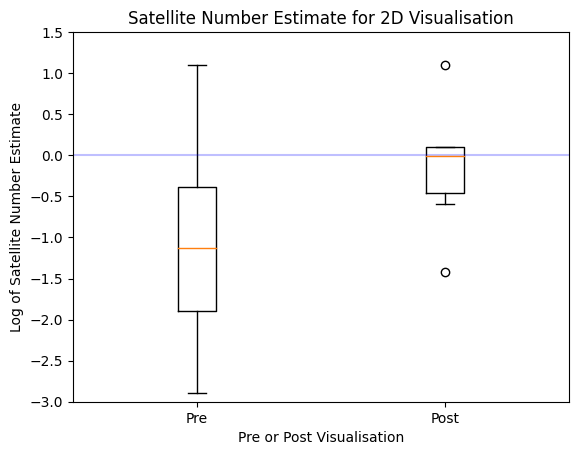

In [25]:
plt.boxplot([pre_2d_diff['SatNum'], post_2d_diff['SatNum']])
plt.xticks([1, 2], ['Pre', 'Post'])

plt.ylabel('Log of Satellite Number Estimate')
plt.xlabel('Pre or Post Visualisation')
plt.title("Satellite Number Estimate for 2D Visualisation")

plt.ylim(-3, 1.5)
plt.axhline(y=0, color='b', linestyle='-', alpha=0.25)

plt.show()

In [26]:
# Perform the actual t test for the number of satellites
ttest_rel(pre_2d_diff['SatNum'], post_2d_diff['SatNum'], alternative="two-sided")

Ttest_relResult(statistic=-3.1185279313259344, pvalue=0.009775623500227256)

In [27]:
# Perform the actual test for the closer satellite speed
#wilcoxon(pre_2d_diff['Close'], post_2d_diff['Close'])

### AR Visualisation

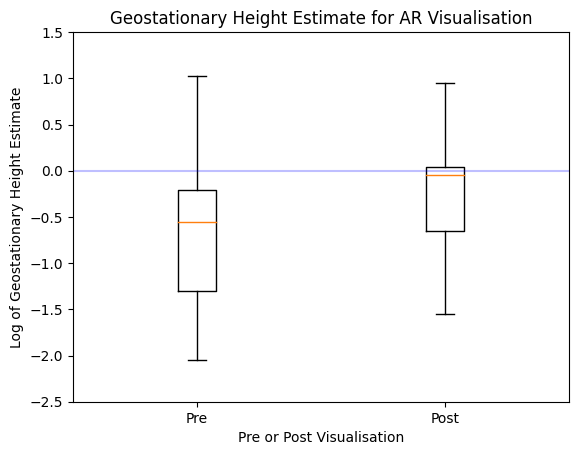

In [28]:
plt.boxplot([pre_ar_diff['GeoHeight'], post_ar_diff['GeoHeight']])
plt.xticks([1, 2], ['Pre', 'Post'])

plt.ylabel('Log of Geostationary Height Estimate')
plt.xlabel('Pre or Post Visualisation')
plt.title("Geostationary Height Estimate for AR Visualisation")

plt.ylim(-2.5, 1.5)
plt.axhline(y=0, color='b', linestyle='-', alpha=0.25)

plt.show()

In [29]:
# Perform the actual t test for the geostationary height
ttest_rel(pre_ar_diff['GeoHeight'], post_ar_diff['GeoHeight'], alternative="two-sided")

Ttest_relResult(statistic=-1.53259411874685, pvalue=0.156379955906523)

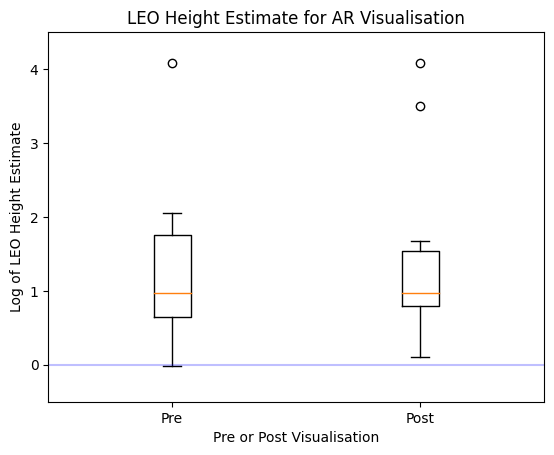

In [30]:
plt.boxplot([pre_ar_diff['LeoHeight'], post_ar_diff['LeoHeight']])
plt.xticks([1, 2], ['Pre', 'Post'])

plt.ylabel('Log of LEO Height Estimate')
plt.xlabel('Pre or Post Visualisation')
plt.title("LEO Height Estimate for AR Visualisation")

plt.ylim(-0.5, 4.5)
plt.axhline(y=0, color='b', linestyle='-', alpha=0.25)

plt.show()

In [31]:
# Perform the actual t test for the LEO height
ttest_rel(pre_ar_diff['LeoHeight'], post_ar_diff['LeoHeight'], alternative="two-sided")

Ttest_relResult(statistic=-0.7048575259851219, pvalue=0.49698705672004995)

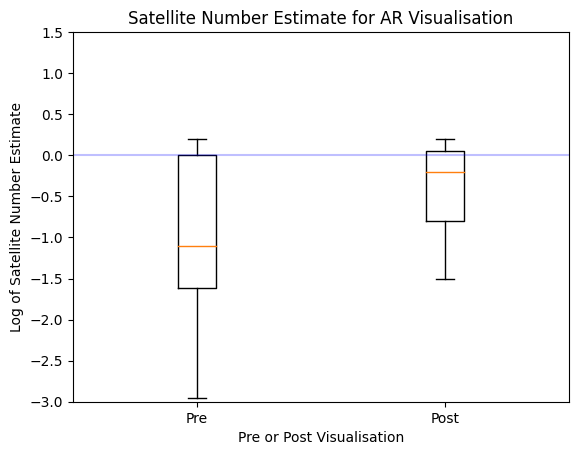

In [32]:
plt.boxplot([pre_ar_diff['SatNum'], post_ar_diff['SatNum']])
plt.xticks([1, 2], ['Pre', 'Post'])

plt.ylabel('Log of Satellite Number Estimate')
plt.xlabel('Pre or Post Visualisation')
plt.title("Satellite Number Estimate for AR Visualisation")

plt.ylim(-3, 1.5)
plt.axhline(y=0, color='b', linestyle='-', alpha=0.25)

plt.show()

In [33]:
# Perform the actual t test for the number of satellites
ttest_rel(pre_ar_diff['SatNum'], post_ar_diff['SatNum'], alternative="two-sided")

Ttest_relResult(statistic=-1.5243839307927776, pvalue=0.15839341275278435)